# FISH - Data interpretation - A Python interactive notebook to interpret FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.

```

### Notebook summary 


- Load a directory with data quantified by FISH_pipeline.ipynb
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Compares quantifications for multiple conditions in a single plot
- Compares mRNA spots in the  nucleus, cytosol and the comple cell.
  
----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

## Importing libraries

In [1]:
import sys
import pathlib
import shutil
import warnings
warnings.filterwarnings("ignore")

## Defining paths

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa
# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
local_folder_path
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'

## List of folders to process

In [3]:
def Huys_short(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' )
    list_labels = [ 'woSTM','18minTPL_5uM','5hTPL_5uM']
    plot_title_suffix= "MS2_CY5_TPL_short"
    mandatory_substring = mandatory_substring      #'nuc_80__cyto_0__psfz_350__psfyx_160__ts_220'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

In [4]:
def dusp__dirs(mandatory_substring):
    list_dirs=(
    'smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224',
    'smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_10min_20220224',   
    'smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_20min_20220224',
    'smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_30min_20220224',
    'smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_40min_20220224' ,  
    'smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_50min_20220224',
    'smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_60min_20220224',
    'smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224',
    'smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224',
    'smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224',
    'smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224',
    'smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_180min_20220224' )
    list_labels = [ 'wo','10min','20min','30min','40min','50min','60min','75min','90min','120min','150min','180min']
    plot_title_suffix= "DUSP1_Dex"
    mandatory_substring = mandatory_substring #'nuc_100__cyto_220__psfz_300__psfyx_105'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

----

# Running the codes

----

In [5]:
#list_dirs, list_labels, plot_title_suffix, mandatory_substring = Huys_short(mandatory_substring='nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400')
list_dirs, list_labels, plot_title_suffix, mandatory_substring = dusp__dirs(mandatory_substring='nuc_100__cyto_220__psfz_320__psfyx_120')

minimum_spots_cluster = 3 # Just for the plotting
connect_to_NAS = True

# creating a folder to store all plots
destination_folder = pathlib.Path().absolute().joinpath('results', 'dist_'+plot_title_suffix+'__'+mandatory_substring)


## Connecting to NAS and extracting data

In [6]:
%%capture
df_all, df_cyto, df_nuc, df_transcription_sites, list_spots_total, list_spots_nuc, list_spots_cytosol, list_number_cells, list_transcription_sites, list_cell_size, list_dataframes, list_nuc_size, list_cyto_size  = fa.Utilities.extract_data_interpretation(list_dirs, path_to_config_file,current_dir, mandatory_substring, local_folder_path, list_labels, share_name='share',minimum_spots_cluster=minimum_spots_cluster, connect_to_NAS=connect_to_NAS, spot_type=0, remove_extreme_values=False)


## Plotting

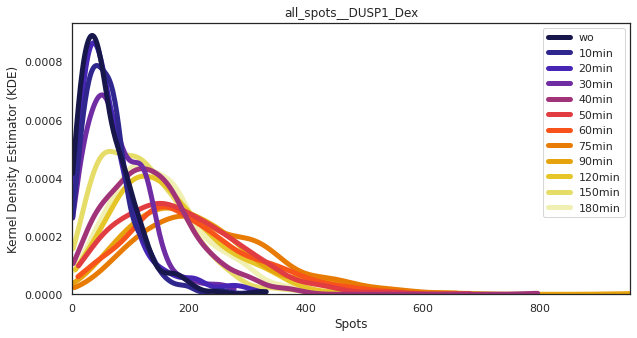

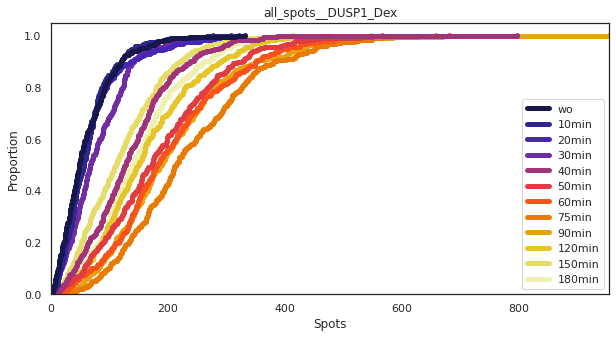

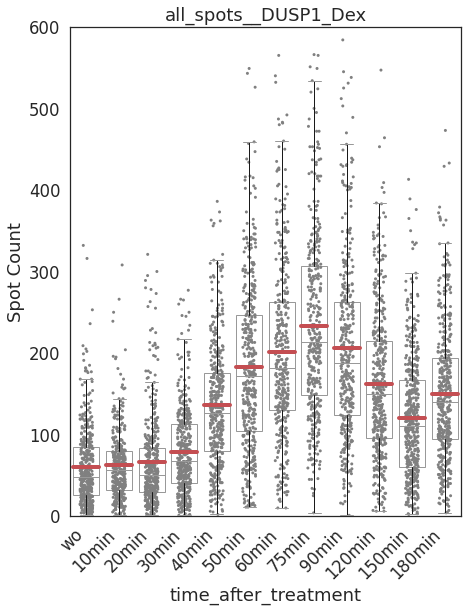

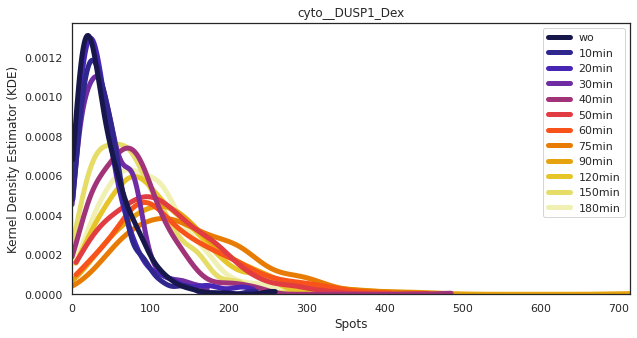

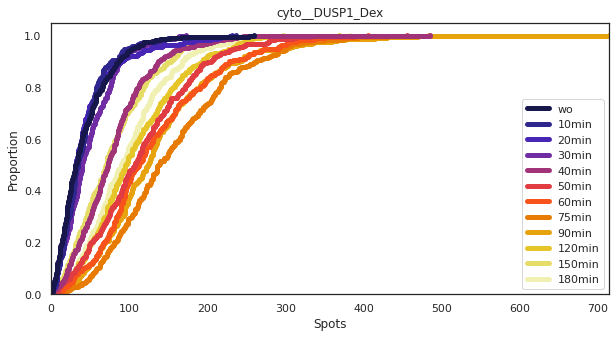

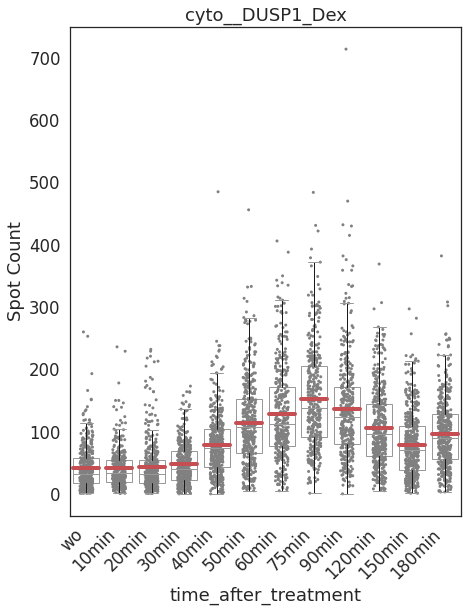

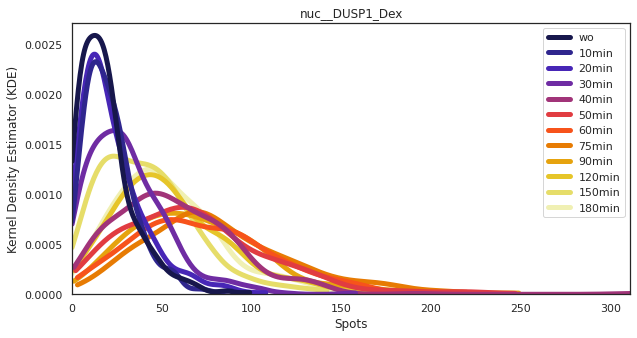

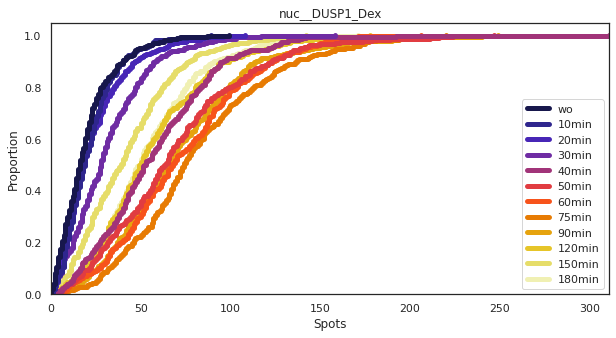

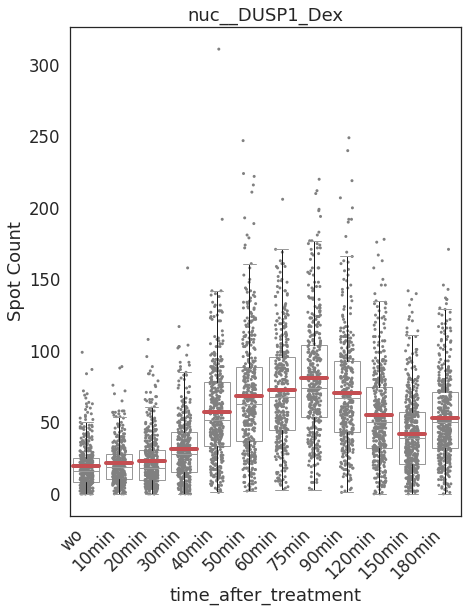

In [7]:
fa.Plots.plot_interpretation_distributions (df_all, df_cyto, df_nuc, destination_folder, plot_title_suffix=plot_title_suffix,y_lim_values_all_spots=(0,600))

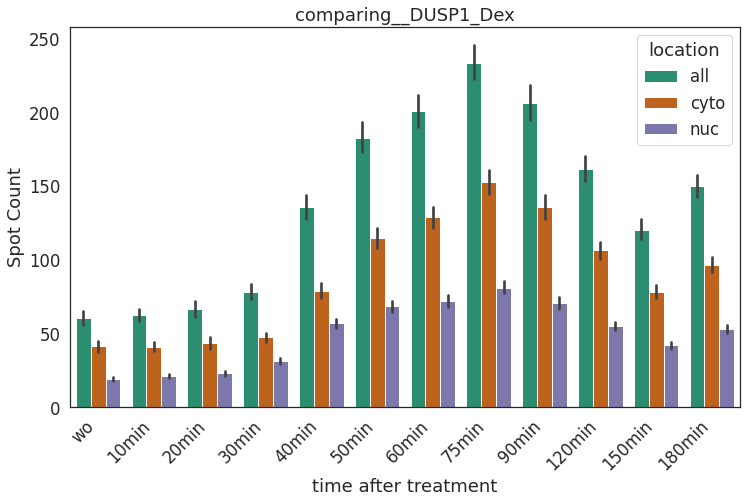

In [8]:
# Plot that compares nuc, cyto, and spots in all cell.
plot_title_comparing = 'comparing__'+plot_title_suffix
fa.Plots.plot_comparing_df(df_all,df_cyto,df_nuc,plot_title_comparing,destination_folder)

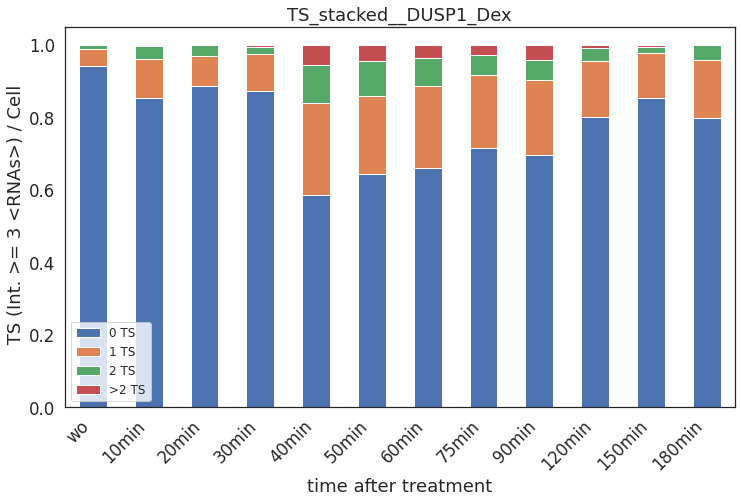

In [9]:
plot_title = 'TS_stacked__'+plot_title_suffix
fa.Plots.plot_TS_bar_stacked(df_transcription_sites,plot_title,destination_folder,minimum_spots_cluster,normalize=True)


# Cell and spot intensity

In [10]:
if 'nuc_int_ch_0' in list_dataframes[0].columns:
    column_name = 'nuc_int'
    fa.Plots.compare_intensities_spots_interpretation(df_all, list_dataframes, list_number_cells, list_labels, plot_title_suffix, destination_folder, column_name = column_name)

# Converting Dataframe to use in Brian's Matlab code.

### Use the following  code if only one FISH channel is used.

In [11]:
df_for_model = fa.Utilities.export_data_to_CSV(list_spots_total, list_spots_nuc, list_spots_cytosol, destination_folder, plot_title_suffix)

In [12]:
# remove temporary folder
shutil.rmtree(local_folder_path)